# The problem domain

# Importing libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Importing the dataset

In [113]:
from PIL import Image
import glob

def build_data_frame_by_path(path):
    '''
    Reads the images in a specific path and builds a pandas dataframe containing:
        - filename
        - image reshaped to 1 dimension, out of 3 expected
        - shape of the image
    '''
    files = glob.glob(f"{path}/*.jpg")
    file_names = []
    images = []
    shapes = []

    for full_path in files:
        file_name = full_path.split('/')[-1]
        file_names.append(file_name) # Get the file name only
        img = Image.open(full_path)
        img = np.array(img)
        d1, d2, d3 = img.shape
        images.append(img.reshape(d1 * d2 * d3)) # Transforms the three dimensions into one
        shapes.append((d1, d2, d3))
    
    data = {'filename': file_names, 'image': images, 'shape': shapes}
    return pd.DataFrame(data)

In [114]:
def build_butterflies_dataset(set_name):
    '''
    Creates a pandas data frame using the set_name as the file name and the kaggle base directory.
    Possible values: Testing_set.csv, Training_set.csv
    '''
    file_name = f"/kaggle/input/butterfly-image-classification/{set_name}"
    return pd.read_csv(file_name)

In [115]:
%%time

train_images_dir = "/kaggle/input/butterfly-image-classification/train"
df_train_images = build_data_frame_by_path(train_images_dir)
print(df_train_images.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   image     6499 non-null   object
 2   shape     6499 non-null   object
dtypes: object(3)
memory usage: 152.4+ KB
None
CPU times: user 6.22 s, sys: 1.19 s, total: 7.4 s
Wall time: 11.7 s


In [116]:
training_set_file_name = "Training_set.csv"
df_train_butterflies = build_butterflies_dataset(training_set_file_name)
print(df_train_butterflies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB
None


In [117]:
df_train = pd.merge(df_train_images, df_train_butterflies, how='inner', on='filename')
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   image     6499 non-null   object
 2   shape     6499 non-null   object
 3   label     6499 non-null   object
dtypes: object(4)
memory usage: 203.2+ KB
None


At the end of the importing process, we have a custom dataframe with the file name, the reshaped matrix that corresponds to the images contents, the original shape of the images and the label (or target) of the image, the correct butterfly species.

In [118]:
def plot_original_image(image_raw):
    img = image_raw.reshape(224, 224, 3)
    plt.imshow(img, cmap='binary')
    plt.axis('off')
    plt.show()

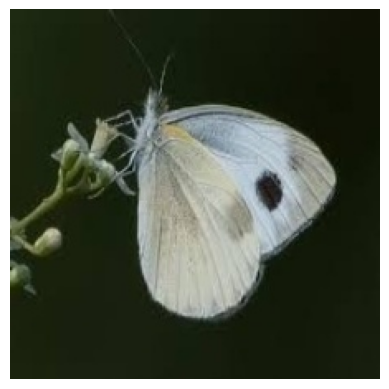

In [119]:
first_image = df_train['image'][0]
plot_original_image(first_image)

Example of image reconstruction

# Understanding the data

In [120]:
print(df_train['label'].value_counts())

label
MOURNING CLOAK              131
SLEEPY ORANGE               107
ATALA                       100
BROWN SIPROETA               99
BANDED ORANGE HELICONIAN     97
                           ... 
AMERICAN SNOOT               74
GOLD BANDED                  73
MALACHITE                    73
CRIMSON PATCH                72
WOOD SATYR                   71
Name: count, Length: 75, dtype: int64


<BarContainer object of 10 artists>

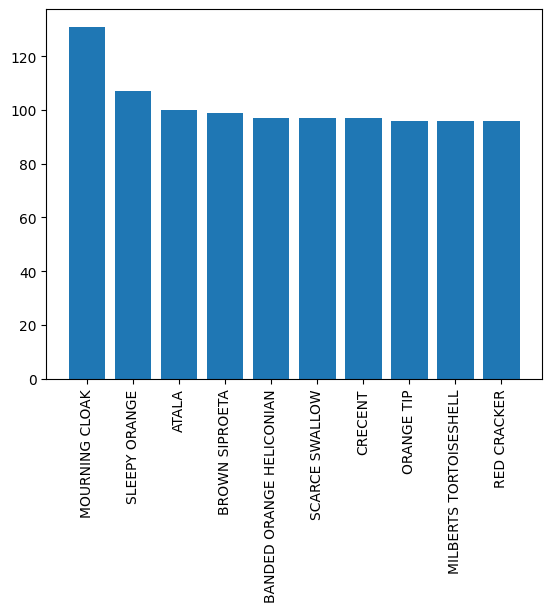

In [121]:
value_counts = df_train['label'].value_counts()[:10]

class_labels = list(value_counts.index)
counts = list(value_counts.values)

plt.xticks(rotation=90)
plt.bar(class_labels, counts)

# Model trainning

In [123]:
# Transform the dataframe column 'image' to a matrix
images_array = np.array(df_train['image'].values)
all_images_matrix = np.vstack(images_array)

X = all_images_matrix
y = df_train['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random forest

In [ ]:
%%time

param_grid = [{
    'max_depth': [2, 4, 8, 16, 32, 64], 
    'min_samples_leaf': [2, 4, 8, 16],
    'n_estimators': [10, 50, 100, 200, 500]
}]

forest_clf = RandomForestClassifier(random_state=42)
rf_gridsearch = GridSearchCV(forest_clf, param_grid, cv=10, scoring='accuracy', refit=True)
rf_gridsearch.fit(X_train, y_train)

print(rf_gridsearch.best_score_)
print(rf_gridsearch.best_params_)